<a href="https://colab.research.google.com/github/davide-ario/BNN/blob/main/Nested-BayesianNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

from warnings import filterwarnings
import h5py
#h5py.run_tests()

import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import seaborn as sns
import sklearn
import theano
import theano.tensor as T
import tensorflow as tf

from sklearn import datasets
from sklearn.datasets import make_moons
#from scipy.special import comb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale

In [2]:
print(f"Running on PyMC3 v{pm.__version__}")


Running on PyMC3 v3.11.4


In [3]:
%config InlineBackend.figure_format = 'retina'
floatX = theano.config.floatX
filterwarnings("ignore")
sns.set_style("white")

We simulate a dataset of 1000 observations, with 1 confounding variable and 1 latent variable correlated with 1 independent variable

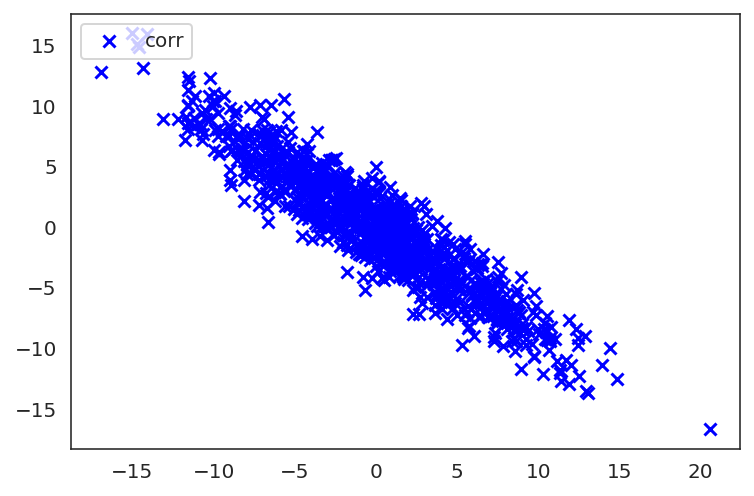

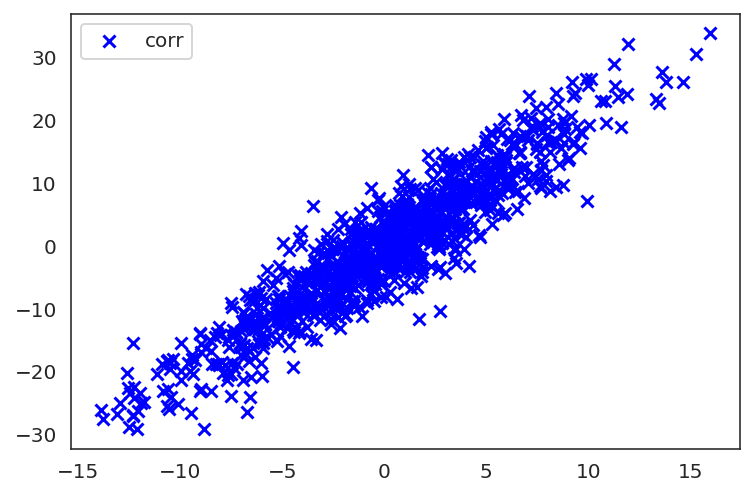

In [81]:
#X= np.random.rand(1000,5)*3
X= np.random.normal(0, 5, size=(1000, 5))
#confounding_var = np.random.rand(1000,)*3
confounding_var = np.random.normal(0, 5, size=(1000,))
#X_0 is a variable correlated with the confounding factor
X[:,0]= -confounding_var+np.random.normal(0, 2, size=(1000,))
#create a latent variable, correlated with X_2
latent_correlated =  2*np.random.normal(0, 2, size=(1000,))+2*X[:,2]

fig = plt.figure()
ax1 = fig.add_subplot(111)    
ax1.scatter(X[:,0],confounding_var, c='b', marker='x', label='corr')
plt.legend(loc='upper left');
plt.show()

fig = plt.figure()
ax1 = fig.add_subplot(111)    
ax1.scatter(X[:,2],latent_correlated, c='b', marker='x', label='corr')
plt.legend(loc='upper left');
plt.show()


The dependent variable is computed as   $Y = 2+3*X_0 - 2*{X_1}^2 + 8* X_1+7*X_2 - 4*{X_3}^3 + 3*sin(X_4) + confoundingVariable + latentCorrelatedVariable + 𝛆$ 
where 𝛆 is N(0,2).

In [122]:
Y = 2+ X[:,0]*3-2*X[:,1]**2+8*X[:,1]+7*X[:,2]-4*X[:,3]**3+3*np.sin(X[:,4])+np.random.normal(0, 2, 1000)+ confounding_var+latent_corr
X = X.astype(floatX)
Y = Y.astype(floatX)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5)

Correlation between Y and $X_0$

In [123]:
import scipy.stats
r, p = scipy.stats.pearsonr(Y, X[:,0])
np.corrcoef(Y, X[:,0])


array([[1.        , 0.00698544],
       [0.00698544, 1.        ]])

ADVI Linear regression estimation (misspecified function)
 
 $Y = const+b_0*X_0 - b_1*{X_1}+b_2*X_2 - b_3*{X_3} + b_4*X_4  + 𝛆$ 

Finished [100%]: Average Loss = 4,447.7


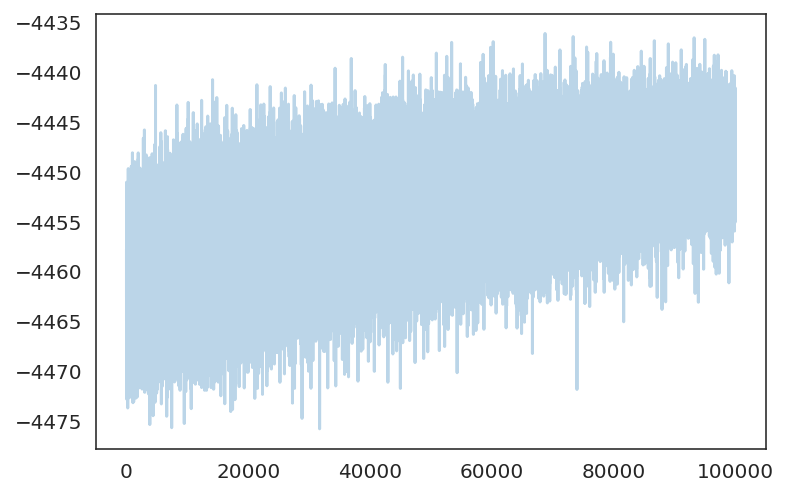

In [124]:
#benchmark model
with pm.Model() as linear_regression:
    ann_input = pm.Data("ann_input", X_train)
    ann_output = pm.Data("ann_output", Y_train)
#        delta = pm.HalfCauchy('delta', 1)
    # Weights from input to hidden layer
    sigma = pm.HalfCauchy('sigma', 5)
    alpha = pm.Normal("alpha", 0, sigma=10)

    # Weights from 1st to 2nd layer
    beta = pm.Normal("beta", 0, sigma=10, shape=5)
#              # Weights from 1st to 2nd layer
#        weights_1_2 = pm.Normal("w_2_2", 0, sigma=1, shape=(n_hidden, n_hidden), testval=init_2)
    # Weights from hidden layer to output

#    mu = alpha + pm.math.dot(ann_input[], beta)
    mu = alpha + ann_input[:,0]*beta[0]+ann_input[:,1]*beta[1]+ann_input[:,2]*beta[2]+ann_input[:,3]*beta[3]+ann_input[:,4]*beta[4]

    # Binary classification -> Bernoulli likelihood
    out = pm.Normal(
        "out", mu=mu,
        sigma=sigma,
        observed=ann_output,
        total_size=Y_train.shape[0])  # IMPORTANT for minibatches)

    
with linear_regression:
    inference = pm.ADVI()
    appr = pm.fit(n=200000, method=inference)

plt.plot(-inference.hist[100000:], label="new ADVI", alpha=0.3)
trace_linear = appr.sample(draws=5000)

Parameter value

In [125]:
#pm.traceplot(trace_linear, varnames=["alpha", "beta"])
pm.summary(trace_linear,)


Got error No model on context stack. trying to find log_likelihood in translation.
arviz - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,2.200,10.408,-17.960,21.004,0.147,0.104,4988.0,4919.0,NaN
beta[0],-3.579,8.682,-19.643,12.941,0.125,0.091,4842.0,4343.0,NaN
beta[1],-3.901,8.713,-20.523,12.578,0.124,0.088,4929.0,4748.0,NaN
beta[2],0.983,8.786,-15.037,18.127,0.123,0.087,5135.0,5058.0,NaN
beta[3],-59.910,8.818,-77.031,-43.935,0.130,0.092,4584.0,4521.0,NaN
beta[4],-0.437,8.721,-16.197,17.007,0.125,0.088,4874.0,4745.0,NaN
sigma,1671.822,58.838,1565.467,1784.020,0.838,0.593,4938.0,4717.0,NaN


In [126]:
# Make predictions using the testing set
pm.set_data(new_data={"ann_input": X_test, "ann_output": Y_test}, model=linear_regression)
ppc_linear = pm.sample_posterior_predictive(
    trace_linear, samples=500, progressbar=True, model=linear_regression
)

Y_pred_linear = ppc_linear["out"].mean(axis=0)


In [127]:
Square_errorLinearADVI=sum((Y_pred_linear-Y_test)**2)
Square_errorLinearADVI


1104527713.6984785

OLS Model estimation (misspecified function)

In [128]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X_train, Y_train)

# Make predictions using the testing set
y_lin_pred = regr.predict(X_test)

# The coefficients
print("Intercept: \n", regr.intercept_)
print("Coefficients: \n", regr.coef_)
# The OLS mean squared error
print("OLS Mean squared error: %.2f" % mean_squared_error(Y_test, y_lin_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(Y_test, y_lin_pred))
# The ADVI mean squared error
print("ADVI Mean squared error: %.2f" % mean_squared_error(Y_test, Y_pred_linear))
#OLS sum of squared error
print("OLS sum of squared error: %.2f" % sum((y_lin_pred-Y_test)**2))

#ADVi sum of squared error
print("ADVI sum of squared error: %.2f" % Square_errorLinearADVI)


Intercept: 
 48.89836442929138
Coefficients: 
 [   6.9541258    -9.99157436   -0.91085682 -278.9388967    -7.95664375]
OLS Mean squared error: 1163811.41
Coefficient of determination: 0.59
ADVI Mean squared error: 2209055.43
OLS sum of squared error: 581905703.60
ADVI sum of squared error: 1104527713.70


In [ ]:
Evaluate performance linear model

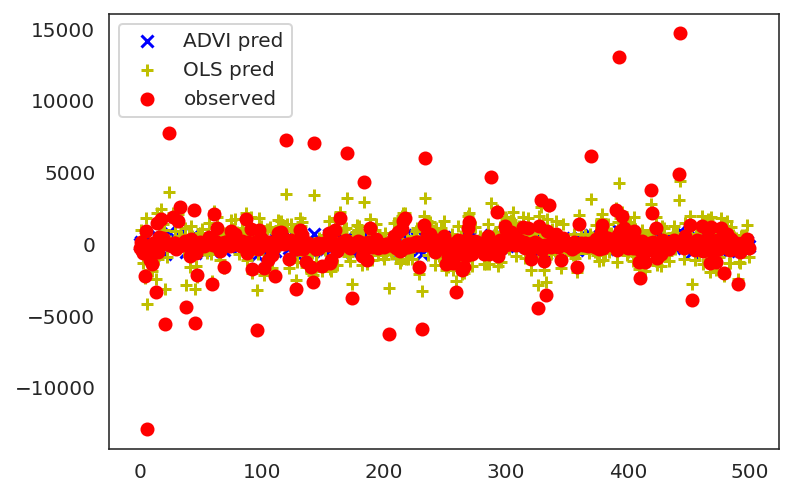

In [129]:

# linear prediction   
fig = plt.figure()
ax1 = fig.add_subplot(111)    
x = range(500)
ax1.scatter(x,Y_pred_linear, c='b', marker='x', label='ADVI pred')
ax1.scatter(x,y_lin_pred, c='y', marker='+', label='OLS pred')
ax1.scatter(x,Y_test, c='r', marker="o", label='observed')
plt.legend(loc='upper left');
plt.show()


We define a function to create a simple Bayesian Neural Network, with 2 hidden layer


In [130]:
def construct_nn(ann_input, ann_output):
    n_hidden = 30

    # Initialize random weights between each layer
    init_1 = np.random.randn(X.shape[1], n_hidden).astype(floatX)
    init_2 = np.random.randn(n_hidden, n_hidden).astype(floatX)
    init_out = np.random.randn(n_hidden).astype(floatX)

    with pm.Model() as neural_network:
        # Trick: Turn inputs and outputs into shared variables using the data container pm.Data
        # It's still the same thing, but we can later change the values of the shared variable
        # (to switch in the test-data later) and pymc3 will just use the new data.
        # Kind-of like a pointer we can redirect.
        # For more info, see: http://deeplearning.net/software/theano/library/compile/shared.html
        ann_input = pm.Data("ann_input", X_train)
        ann_output = pm.Data("ann_output", Y_train)
        err = pm.Normal("err", 0, sigma=1)
        load1 = pm.Normal("load1", 0, sigma=1)
        load2 = pm.Normal("load2", 0, sigma=1)
        load3 = pm.Normal("load3", 0, sigma=1)

#        delta = pm.HalfCauchy('delta', 1)
        # Weights from input to hidden layer
        weights_in_1 = pm.Normal("w_in_1", 0, sigma=1, shape=(X.shape[1], n_hidden), testval=init_1)

        # Weights from 1st to 2nd layer
        weights_1_2 = pm.Normal("w_1_2", 0, sigma=1, shape=(n_hidden, n_hidden), testval=init_2)
#              # Weights from 1st to 2nd layer
#        weights_1_2 = pm.Normal("w_2_2", 0, sigma=1, shape=(n_hidden, n_hidden), testval=init_2)
        # Weights from hidden layer to output
        weights_2_2 = pm.Normal("w_2_2", 0, sigma=1, shape=(n_hidden, n_hidden), testval=init_2)

        weights_2_out = pm.Normal("w_2_out", 0, sigma=1, shape=(n_hidden,), testval=init_out)

        # Build neural-network using tanh activation function
        act_1 = T.nnet.relu(pm.math.dot(ann_input, weights_in_1))+load1*err
        act_2 = T.nnet.relu(pm.math.dot(act_1, weights_1_2))+load2*err
        act_3 = T.nnet.relu(pm.math.dot(act_2, weights_2_2))+load3*err
#        act_1 = T.dot(ann_input, weights_in_1)+err
#        act_2 = T.dot(act_1, weights_1_2)+err
#
#        act_3 = T.dot(act_2, weights_2_2)+err

#
#        act_1 = T.dot(ann_input, weights_in_1)
#        act_2 = T.dot(act_1, weights_1_2)
        

        act_out = T.dot(act_3, weights_2_out)+err

        # Binary classification -> Bernoulli likelihood
        out = pm.Normal(
            "out", mu=act_out,
            sigma=1,
            observed=ann_output,
            total_size=Y_train.shape[0],  # IMPORTANT for minibatches
        )
    return neural_network



A bayesian neural network with two hidden layer is created

In [131]:
neural_network = construct_nn(X_train, Y_train)

The BNN is trained with mini-batch estimation

In [132]:

minibatch_x = pm.Minibatch(X_train, batch_size=50)
minibatch_y = pm.Minibatch(Y_train, batch_size=50)
neural_network_minibatch = construct_nn(minibatch_x, minibatch_y)

with neural_network_minibatch:
  approx = pm.fit(120000, method=pm.ADVI())
    
    

Finished [100%]: Average Loss = 8.2512e+05


We look at the convergence plot of the BNN 

Text(0.5, 0, 'iteration')

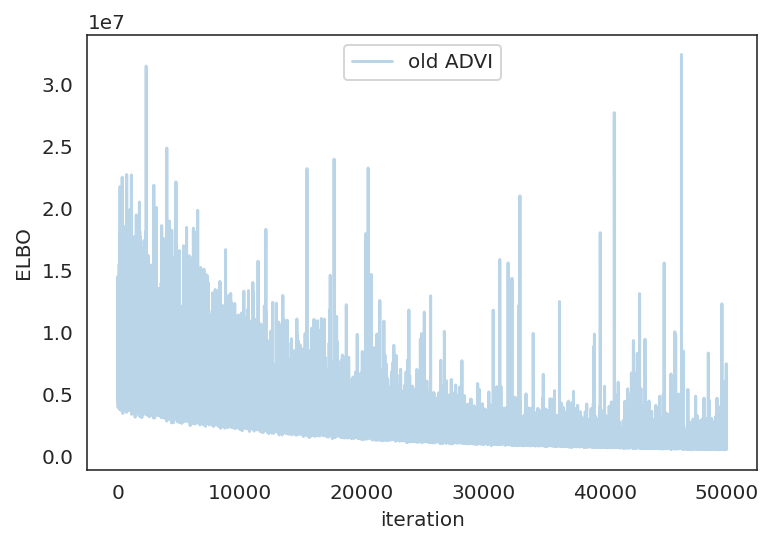

In [133]:
#plt.plot(-inference.hist, label="new ADVI", alpha=0.3)
plt.plot(approx.hist[70000:], label="old ADVI", alpha=0.3)
plt.legend()
plt.ylabel("ELBO")
plt.xlabel("iteration")

We can observe the value estimated for the weighting matrix 

Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
arviz - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
load1,-1.906,0.003,-1.912,-1.901,0.000,0.000,5051.0,4238.0,NaN
load2,-3.356,0.015,-3.383,-3.326,0.000,0.000,4839.0,4824.0,NaN
load3,1.565,0.069,1.435,1.693,0.001,0.001,4884.0,4629.0,NaN


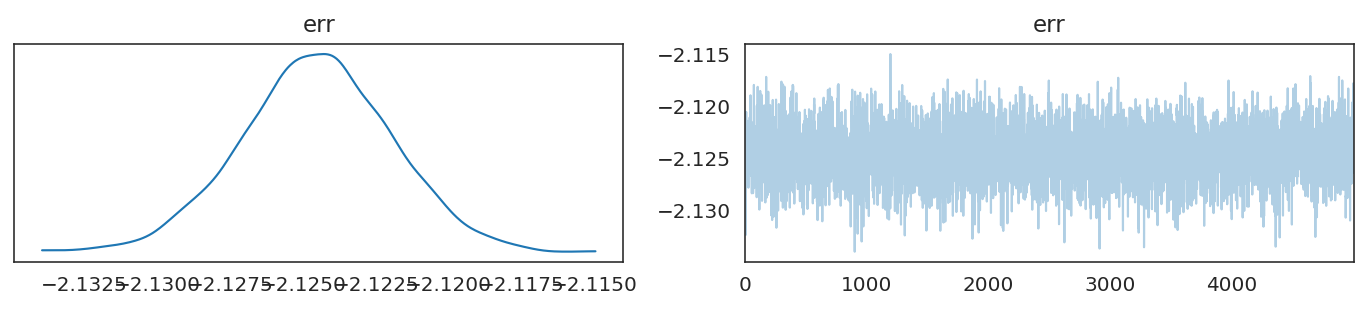

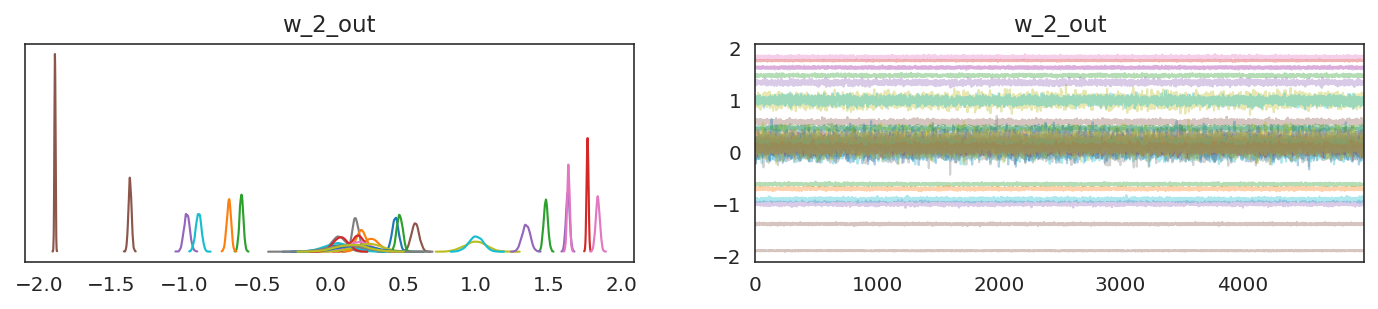

In [134]:
trace = approx.sample(draws=5000)
pm.traceplot(trace, var_names="err")
pm.traceplot(trace, var_names="w_2_out")
pm.summary(trace, var_names=["load1","load2","load3"])


Create BNN predictions

In [135]:
pm.set_data(new_data={"ann_input": X_test, "ann_output": Y_test}, model=neural_network_minibatch)
ppc = pm.sample_posterior_predictive(
    trace, samples=500, progressbar=True, model=neural_network_minibatch
)

predBNN = ppc["out"].mean(axis=0)
predBNN.mean(axis=0)



26.434306786411355

BNN is extremely better in predicting when the function is misspecified

BNN Mean squared error: 221235.91
OLS Mean squared error: 1163811.41


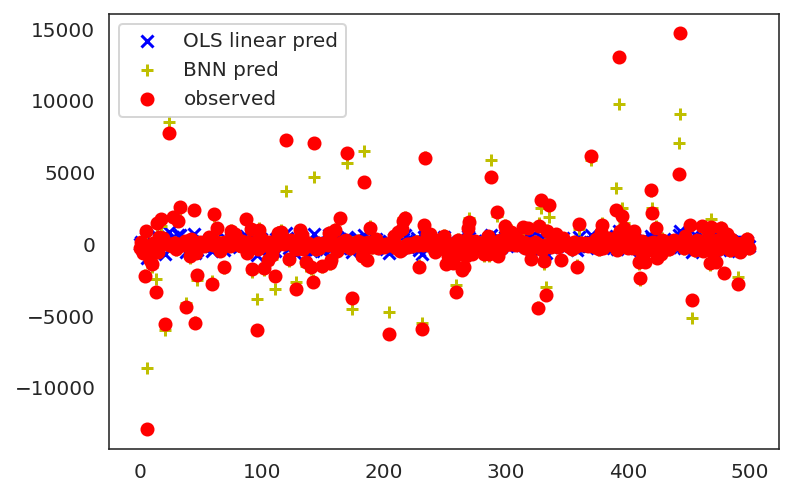

In [136]:
# The BNN mean squared error
print("BNN Mean squared error: %.2f" % mean_squared_error(Y_test, predBNN))
# The OLS mean squared error
print("OLS Mean squared error: %.2f" % mean_squared_error(Y_test, y_lin_pred))

# linear prediction   
fig = plt.figure()
ax1 = fig.add_subplot(111)    
x = range(500)
ax1.scatter(x,Y_pred_linear, c='b', marker='x', label='OLS linear pred')
ax1.scatter(x,predBNN, c='y', marker='+', label='BNN pred')
ax1.scatter(x,Y_test, c='r', marker="o", label='observed')
plt.legend(loc='upper left');
plt.show()

Now we create a Nested Bayesian Neural Network. This NBNN is made up by two different BNN. For each variable the BNN chose which model is more appropiate, applying a specific weight.

In [137]:
def construct_nnNEW(ann_input, ann_output):
    n_hidden = 10

    # Initialize random weights between each layer
    init_1 = np.random.randn(X.shape[1], n_hidden).astype(floatX)
    init_2 = np.random.randn(n_hidden, n_hidden).astype(floatX)
    init_out = np.random.randn(n_hidden).astype(floatX)
    init_b_1 = np.random.randn(n_hidden).astype(floatX)
    init_b_2 = np.random.randn(n_hidden).astype(floatX)
    init_b_3 = np.random.randn(n_hidden).astype(floatX)

    init_b_out = np.random.randn(1).astype(floatX)

#    init_1s = np.random.randn(X.shape[1], n_hidden).astype(floatX)
#    init_2s = np.random.randn(n_hidden, n_hidden).astype(floatX)
#    init_outs = np.random.randn(n_hidden).astype(floatX)
#    init_b_1s = np.random.randn(n_hidden).astype(floatX)
#    init_b_2s = np.random.randn(n_hidden).astype(floatX)
#    init_b_3s = np.random.randn(n_hidden).astype(floatX)
#
#    init_b_outs = np.random.randn(1).astype(floatX)






    with pm.Model() as neural_network:
        # Trick: Turn inputs and outputs into shared variables using the data container pm.Data
        # It's still the same thing, but we can later change the values of the shared variable
        # (to switch in the test-data later) and pymc3 will just use the new data.
        # Kind-of like a pointer we can redirect.
        # For more info, see: http://deeplearning.net/software/theano/library/compile/shared.html
        ann_input = pm.Data("ann_input", X_train)
        ann_output = pm.Data("ann_output", Y_train)
        err = pm.Normal("err", 0, sigma=1, shape=(X_train.shape[0],))
        errs = pm.Normal("errs", 0, sigma=1, shape=(X_train.shape[0],))

        model_sel=pm.Uniform('model_sel', lower=0, upper=1, shape=(X_train.shape[1],))
#        delta = pm.HalfCauchy('delta', 1)
        # Weights from input to hidden layer
        weights_in_1 = pm.Normal("w_in_1", 0, sigma=1, shape=(X.shape[1], n_hidden), testval=init_1)
        bias1 = pm.Normal("bias1", 0, sigma=1, shape=n_hidden, testval=init_b_1)

        # Weights from 1st to 2nd layer
        weights_1_2 = pm.Normal("w_1_2", 0, sigma=1, shape=(n_hidden, n_hidden), testval=init_2)
        bias2 = pm.Normal("bias2", 0, sigma=1, shape=n_hidden, testval=init_b_2)

#              # Weights from 1st to 2nd layer
#        weights_1_2 = pm.Normal("w_2_2", 0, sigma=1, shape=(n_hidden, n_hidden), testval=init_2)
        # Weights from hidden layer to output
        weights_2_2 = pm.Normal("w_2_2", 0, sigma=1, shape=(n_hidden, n_hidden), testval=init_2)
        bias3 = pm.Normal("bias3", 0, sigma=1, shape=n_hidden, testval=init_b_3)

        weights_2_out = pm.Normal("w_2_out", 0, sigma=1, shape=(n_hidden,), testval=init_out)

        # Build neural-network using tanh activation function
#        mu_para= alpha + ann_input[:,0]*beta[0]+ann_input[:,1]*beta[1]
        input_continuos = ann_input*(1-model_sel)
        act_1 = T.nnet.relu(pm.math.dot(input_continuos, weights_in_1)+bias1)
        act_2 = T.nnet.relu(pm.math.dot(act_1, weights_1_2)+bias2)
        act_3 = T.nnet.relu(pm.math.dot(act_2, weights_2_2)+bias3)
#        act_1 = T.dot(ann_input, weights_in_1)+err
#        act_2 = T.dot(act_1, weights_1_2)+err
#
#        act_3 = T.dot(act_2, weights_2_2)+err

#        # Build neural-network using tanh activation function

#        act_1 = T.dot(ann_input, weights_in_1)
#        act_2 = T.dot(act_1, weights_1_2)

        act_out = T.dot(act_3, weights_2_out)+err


#        errs = pm.Normal("errs", 0, sigma=1, shape=(X_train.shape[0],))

#        delta = pm.HalfCauchy('delta', 1)
        # Weights from input to hidden layer
        ##data to point
        
        ##
        weights_in_1s = pm.Normal("w_in_1s", 0, sigma=1, shape=(X.shape[1], n_hidden), testval=init_1)
        bias1s = pm.Normal("bias1s", 0, sigma=1, shape=n_hidden, testval=init_b_1)

        # Weights from 1st to 2nd layer
        weights_1_2s = pm.Normal("w_1_2s", 0, sigma=1, shape=(n_hidden, n_hidden), testval=init_2)
        bias2s = pm.Normal("bias2s", 0, sigma=1, shape=n_hidden, testval=init_b_2)

#              # Weights from 1st to 2nd layer
#        weights_1_2 = pm.Normal("w_2_2", 0, sigma=1, shape=(n_hidden, n_hidden), testval=init_2)
        # Weights from hidden layer to output
        weights_2_2s = pm.Normal("w_2_2s", 0, sigma=1, shape=(n_hidden, n_hidden), testval=init_2)
        bias3s = pm.Normal("bias3s", 0, sigma=1, shape=n_hidden, testval=init_b_3)

        weights_2_outs = pm.Normal("w_2_outs", 0, sigma=1, shape=(n_hidden,), testval=init_out)

        # Build neural-network using tanh activation function
#        mu_para= alpha + ann_input[:,0]*beta[0]+ann_input[:,1]*beta[1]
        input_discrete = ann_input*model_sel

        act_1s = pm.math.tanh(pm.math.dot(input_discrete, weights_in_1s)+bias1s)
        act_2s = pm.math.tanh(pm.math.dot(act_1s, weights_1_2s)+bias2s)
        act_3s = pm.math.tanh(pm.math.dot(act_2s, weights_2_2s)+bias3s)
#        act_1 = T.dot(ann_input, weights_in_1)+err
#        act_2 = T.dot(act_1, weights_1_2)+err
#
#        act_3 = T.dot(act_2, weights_2_2)+err

#        # Build neural-network using tanh activation function

#        act_1 = T.dot(ann_input, weights_in_1)
#        act_2 = T.dot(act_1, weights_1_2)

        act_outs = pm.math.sigmoid(pm.math.dot(act_3s, weights_2_outs)+errs)

        # Binary classification -> Bernoulli likelihood
        out = pm.Normal(
            "out", mu=act_out+act_outs,
            sigma=1,
            observed=ann_output,
            total_size=Y_train.shape[0],  # IMPORTANT for minibatches
        )
    return neural_network


We estimate the NBNN with minibatch

In [138]:
minibatch_x = pm.Minibatch(X_train, batch_size=50)
minibatch_y = pm.Minibatch(Y_train, batch_size=50)
neural_network_minibatch = construct_nnNEW(minibatch_x, minibatch_y)
with neural_network_minibatch:
    approx = pm.fit(160000, method=pm.ADVI())

trace = approx.sample(draws=5000)

Finished [100%]: Average Loss = 3.0071e+05


NBNN predictions are computed below

In [139]:
pm.set_data(new_data={"ann_input": X_test, "ann_output": Y_test}, model=neural_network_minibatch)
ppc = pm.sample_posterior_predictive(
    trace, samples=500, progressbar=True, model=neural_network_minibatch
)

predNBNN = ppc["out"].mean(axis=0)
predNBNN.mean(axis=0)

20.534845332688842

Now we compare OLS, BNN and NBNN average squared prediction error. NBNN perform better than the simple BNN

Nested-BNN Mean squared error: 62598.40
BNN Mean squared error: 221235.91
OLS Mean squared error: 1163811.41


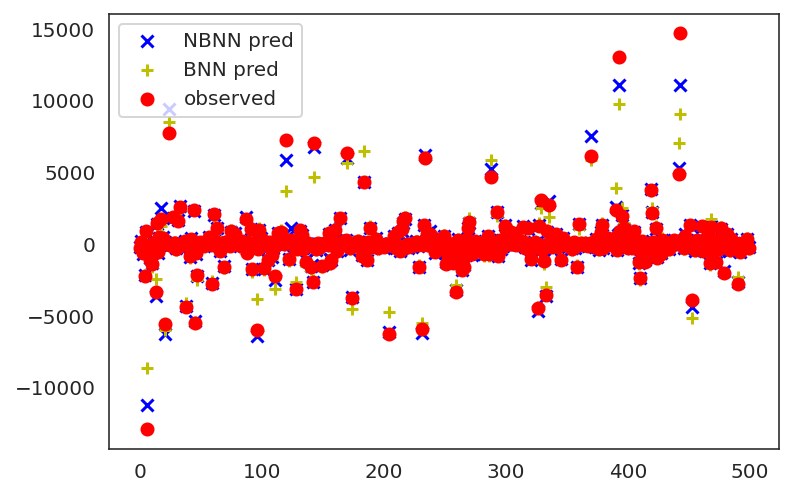

In [140]:
# The Nested-BNN mean squared error
print("Nested-BNN Mean squared error: %.2f" % mean_squared_error(Y_test, predNBNN))
# The BNN mean squared error
print("BNN Mean squared error: %.2f" % mean_squared_error(Y_test, predBNN))
# The OLS mean squared error
print("OLS Mean squared error: %.2f" % mean_squared_error(Y_test, y_lin_pred))

# linear prediction   
fig = plt.figure()
ax1 = fig.add_subplot(111)    
x = range(500)
ax1.scatter(x,predNBNN, c='b', marker='x', label='NBNN pred')
ax1.scatter(x,predBNN, c='y', marker='+', label='BNN pred')
ax1.scatter(x,Y_test, c='r', marker="o", label='observed')
plt.legend(loc='upper left');
plt.show()


It is possible to estimate the marginal effect of each independent variable on the observed (dependent) variable, computing average effect and confidence interval

In [ ]:
Compute the marginal impact of independent variables

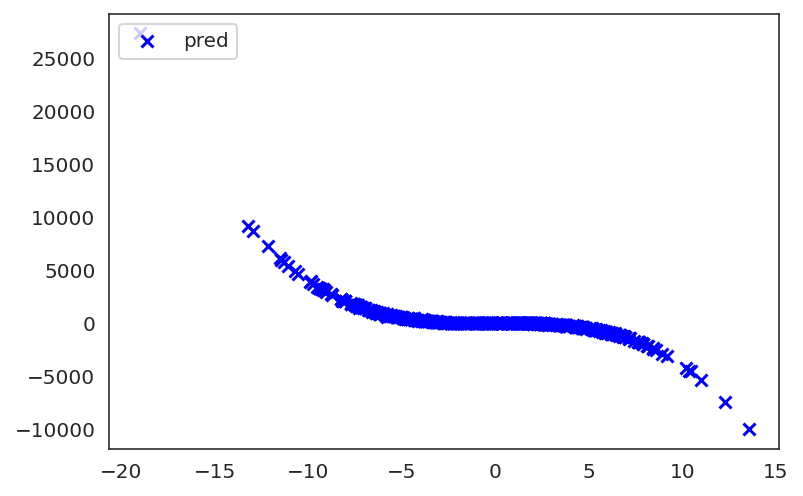

In [144]:
#create counterfactual for training
# I want to capture the impact of X[1]
c=  np.array([1,1,1,0,1])
X_counter = X_train*c

#Y = X[:,0]*3-6*X[:,1]*X[:,1]+8*X[:,1]+np.random.normal(0, .2, 1000)+2+latent
X_counter = X_counter.astype(floatX)

pm.set_data(new_data={"ann_input": X_counter, "ann_output": Y_train}, model=neural_network_minibatch)
ppc_counter = pm.sample_posterior_predictive(
    trace, samples=500, progressbar=True, model=neural_network_minibatch, random_seed=132
)
pred_counter = ppc_counter["out"].mean(axis=0)
pred_counter.mean(axis=0)


##compute impact of x1
##compute fitted data
pm.set_data(new_data={"ann_input": X_train, "ann_output": Y_train}, model=neural_network_minibatch)
ppc_pred = pm.sample_posterior_predictive(
    trace, samples=500, progressbar=True, model=neural_network_minibatch, random_seed=132
)
Y_fitted = ppc_pred["out"].mean(axis=0)


pm.set_data(new_data={"ann_input": X_counter, "ann_output": Y_train}, model=neural_network_minibatch)
ppc_counter = pm.sample_posterior_predictive(
    trace, samples=500, progressbar=True, model=neural_network_minibatch, random_seed=132
)
pred_counter = ppc_counter["out"].mean(axis=0)
pred_counter.mean(axis=0)
Y_impact=Y_fitted-pred_counter



fig = plt.figure()
ax1 = fig.add_subplot(111)    
ax1.scatter(X_train[:,3],Y_impact, c='b', marker='x', label='pred')
plt.legend(loc='upper left');
plt.show()
